In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing all packages

In [63]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
os.chdir("/content/drive/My Drive")

Reading train file. Unseen test file with no labels

In [64]:
df = pd.read_csv('train_indessa.csv')
X_Unseen_test = pd.read_csv('test_indessa.csv')

Here we see that data is slightly imbalanced(class 1 as 23.63% only)

In [65]:
df.loan_status.value_counts() 

0    406601
1    125827
Name: loan_status, dtype: int64

Printing the unique and no of unique values in each of the categorical columns

In [66]:
print(df.desc.nunique(), df.desc.unique())
print(df.grade.nunique(), df.grade.unique())
print(df.term.nunique(), df.term.unique())
print(df.sub_grade.nunique(), df.sub_grade.unique())
print(df.emp_title.nunique(), df.emp_title.unique())
print(df.emp_length.nunique(), df.emp_length.unique())
print(df.home_ownership.nunique(), df.home_ownership.unique())
print(df.verification_status.nunique(), df.verification_status.unique())
print(df.pymnt_plan.nunique(), df.pymnt_plan.unique())
print(df.purpose.nunique(), df.purpose.unique())
print(df.title.nunique(), df.title.unique())
print(df.addr_state.nunique(), df.addr_state.unique())
print(df.initial_list_status.nunique(), df.initial_list_status.unique())
print(df.application_type.nunique(), df.application_type.unique())
print(df.verification_status_joint.nunique(), df.verification_status_joint.unique())
print(df.last_week_pay.nunique(), df.last_week_pay.unique())
print(df.zip_code.nunique(), df.zip_code.unique())
print(df.batch_enrolled.nunique(), df.batch_enrolled.unique())

70638 [nan
 '> My goal is to obtain a loan to pay off my high credit cards and get out of debt within 3 years.<br>'
 '   > We are requesting this loan to help re-organize our finances after having a tumultuous year that resulted in unexpected medical bills.  I have been in the same line of work for over five years and have been at my current company, which is very stable in the marketplace, for two and a half years.<br>'
 ...
 '   > This loan is for home improvements, remodeling and updating.<br>'
 'Need to consolidate cards to 1 monthly payment.'
 '   > My Deck needs to be replaced. I have $2500 saved up for it, but want to get it installed over the summer. The rates at lending club were worth getting financing for it instead of waiting till I could pay for it outright. <br/>Since leaving grad school I have never been unemployed. My Job requires a security clearance, which I cannot have with a poor credit score.<br/>']
7 ['E' 'B' 'A' 'D' 'C' 'F' 'G']
2 ['36 months' '60 months']
35 ['E

In [67]:
# Taking X & Y in data

y = df['loan_status'].values
X = df.drop(['loan_status'], axis=1)
X.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
type(X_train)

pandas.core.frame.DataFrame

In [69]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_Unseen_test.shape)

(372699, 44) (372699,)
(159729, 44) (159729,)
(354951, 44)


Now we see that desc data is mostly empty , also some of the rows have same data as that present in title column.
Hence, as a workaround if we try to impute this 85%+ missing data in desc column with the same as corresponding title data, 
it will be a situation similar to multicolinearity where two columns would almost be around 90% similar, hence
as we dont have extra info available here for its imputation we are just neglecting this desc column in our 
final training.

In [70]:
print(df['desc'].isna().sum())
print(df.desc.value_counts())

456829
> Debt consolidation<br>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       576
> Debt Consolidation<br>                                                                                                                                                                                      

Encoding below zip_code & batch_enrolled on the basis of frequency of that category in that column, 
as these columns have huge no of categories in them. So as to make this categorical column as numerical. 
We are doing this for train , test data & unseen test.

Mostly the columns which had more than 100 categories

In [71]:
emp_title_Dict_train = X_train['zip_code'].value_counts()
title_Dict_train = X_train['batch_enrolled'].value_counts()

X_train['encoded_zip_code'] = X_train['zip_code'].map(emp_title_Dict_train)
X_train['encoded_batch_enrolled'] = X_train['batch_enrolled'].map(title_Dict_train)

X_train.drop(['zip_code', 'batch_enrolled'], axis=1, inplace=True)

emp_title_Dict_test = X_test['zip_code'].value_counts()
title_Dict_test = X_test['batch_enrolled'].value_counts()

X_test['encoded_zip_code'] = X_test['zip_code'].map(emp_title_Dict_test)
X_test['encoded_batch_enrolled'] = X_test['batch_enrolled'].map(title_Dict_test)

X_test.drop(['zip_code', 'batch_enrolled'], axis=1, inplace=True)

emp_title_Dict_test = X_Unseen_test['zip_code'].value_counts()
title_Dict_test = X_Unseen_test['batch_enrolled'].value_counts()

X_Unseen_test['encoded_zip_code'] = X_Unseen_test['zip_code'].map(emp_title_Dict_test)
X_Unseen_test['encoded_batch_enrolled'] = X_Unseen_test['batch_enrolled'].map(title_Dict_test)

X_Unseen_test.drop(['zip_code', 'batch_enrolled'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [72]:
X_train['encoded_batch_enrolled'].head()

403902    74152.0
208286     7801.0
104199    74152.0
459201    74152.0
478793        NaN
Name: encoded_batch_enrolled, dtype: float64

Encoding below emp_title & title on the basis of frequency of that category in that column, 
as these columns have huge no of categories in them. So as to make this categorical column as numerical. 
We are doing this for train, test & Unseen data

In [73]:
emp_title_Dict_train = X_train['emp_title'].value_counts()
title_Dict_train = X_train['title'].value_counts()

X_train['encoded_emp_title'] = X_train['emp_title'].map(emp_title_Dict_train)
X_train['encoded_title'] = X_train['title'].map(title_Dict_train)

X_train.drop(['emp_title', 'title'], axis=1, inplace=True)

emp_title_Dict_test = X_test['emp_title'].value_counts()
title_Dict_test = X_test['title'].value_counts()

X_test['encoded_emp_title'] = X_test['emp_title'].map(emp_title_Dict_test)
X_test['encoded_title'] = X_test['title'].map(title_Dict_test)

X_test.drop(['emp_title', 'title'], axis=1, inplace=True)

emp_title_Dict_test = X_Unseen_test['emp_title'].value_counts()
title_Dict_test = X_Unseen_test['title'].value_counts()

X_Unseen_test['encoded_emp_title'] = X_Unseen_test['emp_title'].map(emp_title_Dict_test)
X_Unseen_test['encoded_title'] = X_Unseen_test['title'].map(title_Dict_test)

X_Unseen_test.drop(['emp_title', 'title'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Imputing each numerical column with the median value, so as to reduce the effect of outliers in train data

In [74]:
X_train['loan_amnt'] = X_train['loan_amnt'].fillna(X_train['loan_amnt'].median())
X_train['collections_12_mths_ex_med'] = X_train['collections_12_mths_ex_med'].fillna(X_train['collections_12_mths_ex_med'].median())
X_train['funded_amnt'] = X_train['funded_amnt'].fillna(X_train['funded_amnt'].median())
X_train['funded_amnt_inv'] = X_train['funded_amnt_inv'].fillna(X_train['funded_amnt_inv'].median())
X_train['int_rate'] = X_train['int_rate'].fillna(X_train['int_rate'].median())
X_train['annual_inc'] = X_train['annual_inc'].fillna(X_train['annual_inc'].median())
X_train['revol_bal'] = X_train['revol_bal'].fillna(X_train['revol_bal'].median())
X_train['revol_util'] = X_train['revol_util'].fillna(X_train['revol_util'].median())
X_train['total_rec_int'] = X_train['total_rec_int'].fillna(X_train['total_rec_int'].median())
X_train['total_rec_late_fee'] = X_train['total_rec_late_fee'].fillna(X_train['total_rec_late_fee'].median())
X_train['recoveries'] = X_train['recoveries'].fillna(X_train['recoveries'].median())
X_train['collection_recovery_fee'] = X_train['collection_recovery_fee'].fillna(X_train['collection_recovery_fee'].median())
X_train['tot_coll_amt'] = X_train['tot_coll_amt'].fillna(X_train['tot_coll_amt'].median())
X_train['tot_cur_bal'] = X_train['tot_cur_bal'].fillna(X_train['tot_cur_bal'].median())
X_train['total_rev_hi_lim'] = X_train['total_rev_hi_lim'].fillna(X_train['total_rev_hi_lim'].median())
X_train['dti'] = X_train['dti'].fillna(X_train['dti'].median())
X_train['mths_since_last_major_derog'] = X_train['mths_since_last_major_derog'].fillna(X_train['mths_since_last_major_derog'].median())
X_train['mths_since_last_delinq'] = X_train['mths_since_last_delinq'].fillna(X_train['mths_since_last_delinq'].median())
X_train['mths_since_last_record'] = X_train['mths_since_last_record'].fillna(X_train['mths_since_last_record'].median())
X_train['open_acc'] = X_train['open_acc'].fillna(X_train['open_acc'].median())
X_train['total_acc'] = X_train['total_acc'].fillna(X_train['total_acc'].median())
X_train['delinq_2yrs'] = X_train['delinq_2yrs'].fillna(X_train['delinq_2yrs'].median())
X_train['inq_last_6mths'] = X_train['inq_last_6mths'].fillna(X_train['inq_last_6mths'].median())
X_train['pub_rec'] = X_train['pub_rec'].fillna(X_train['pub_rec'].median())
X_train['acc_now_delinq'] = X_train['acc_now_delinq'].fillna(X_train['acc_now_delinq'].median())
X_train['encoded_emp_title'] = X_train['encoded_emp_title'].fillna(X_train['encoded_emp_title'].median())
X_train['encoded_title'] = X_train['encoded_title'].fillna(X_train['encoded_title'].median())
X_train['encoded_zip_code'] = X_train['encoded_zip_code'].fillna(X_train['encoded_zip_code'].median())
X_train['encoded_batch_enrolled'] = X_train['encoded_batch_enrolled'].fillna(X_train['encoded_batch_enrolled'].median())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Imputing each numerical column with the median value, so as to reduce the effect of outliers in test data

In [75]:
X_test['loan_amnt'] = X_test['loan_amnt'].fillna(X_test['loan_amnt'].median())
X_test['collections_12_mths_ex_med'] = X_test['collections_12_mths_ex_med'].fillna(X_test['collections_12_mths_ex_med'].median())
X_test['funded_amnt'] = X_test['funded_amnt'].fillna(X_test['funded_amnt'].median())
X_test['funded_amnt_inv'] = X_test['funded_amnt_inv'].fillna(X_test['funded_amnt_inv'].median())
X_test['int_rate'] = X_test['int_rate'].fillna(X_test['int_rate'].median())
X_test['annual_inc'] = X_test['annual_inc'].fillna(X_test['annual_inc'].median())
X_test['revol_bal'] = X_test['revol_bal'].fillna(X_test['revol_bal'].median())
X_test['revol_util'] = X_test['revol_util'].fillna(X_test['revol_util'].median())
X_test['total_rec_int'] = X_test['total_rec_int'].fillna(X_test['total_rec_int'].median())
X_test['total_rec_late_fee'] = X_test['total_rec_late_fee'].fillna(X_test['total_rec_late_fee'].median())
X_test['recoveries'] = X_test['recoveries'].fillna(X_test['recoveries'].median())
X_test['collection_recovery_fee'] = X_test['collection_recovery_fee'].fillna(X_test['collection_recovery_fee'].median())
X_test['tot_coll_amt'] = X_test['tot_coll_amt'].fillna(X_test['tot_coll_amt'].median())
X_test['tot_cur_bal'] = X_test['tot_cur_bal'].fillna(X_test['tot_cur_bal'].median())
X_test['total_rev_hi_lim'] = X_test['total_rev_hi_lim'].fillna(X_test['total_rev_hi_lim'].median())
X_test['dti'] = X_test['dti'].fillna(X_test['dti'].median())
X_test['mths_since_last_major_derog'] = X_test['mths_since_last_major_derog'].fillna(X_test['mths_since_last_major_derog'].median())
X_test['mths_since_last_delinq'] = X_test['mths_since_last_delinq'].fillna(X_test['mths_since_last_delinq'].median())
X_test['mths_since_last_record'] = X_test['mths_since_last_record'].fillna(X_test['mths_since_last_record'].median())
X_test['open_acc'] = X_test['open_acc'].fillna(X_test['open_acc'].median())
X_test['total_acc'] = X_test['total_acc'].fillna(X_test['total_acc'].median())
X_test['delinq_2yrs'] = X_test['delinq_2yrs'].fillna(X_test['delinq_2yrs'].median())
X_test['inq_last_6mths'] = X_test['inq_last_6mths'].fillna(X_test['inq_last_6mths'].median())
X_test['pub_rec'] = X_test['pub_rec'].fillna(X_test['pub_rec'].median())
X_test['acc_now_delinq'] = X_test['acc_now_delinq'].fillna(X_test['acc_now_delinq'].median())
X_test['encoded_emp_title'] = X_test['encoded_emp_title'].fillna(X_test['encoded_emp_title'].median())
X_test['encoded_title'] = X_test['encoded_title'].fillna(X_test['encoded_title'].median())
X_test['encoded_zip_code'] = X_test['encoded_zip_code'].fillna(X_test['encoded_zip_code'].median())
X_test['encoded_batch_enrolled'] = X_test['encoded_batch_enrolled'].fillna(X_test['encoded_batch_enrolled'].median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Imputing each numerical column with the median value, so as to reduce the effect of outliers in Unseen test data

In [76]:
X_Unseen_test['loan_amnt'] = X_Unseen_test['loan_amnt'].fillna(X_Unseen_test['loan_amnt'].median())
X_Unseen_test['collections_12_mths_ex_med'] = X_Unseen_test['collections_12_mths_ex_med'].fillna(X_Unseen_test['collections_12_mths_ex_med'].median())
X_Unseen_test['funded_amnt'] = X_Unseen_test['funded_amnt'].fillna(X_Unseen_test['funded_amnt'].median())
X_Unseen_test['funded_amnt_inv'] = X_Unseen_test['funded_amnt_inv'].fillna(X_Unseen_test['funded_amnt_inv'].median())
X_Unseen_test['int_rate'] = X_Unseen_test['int_rate'].fillna(X_Unseen_test['int_rate'].median())
X_Unseen_test['annual_inc'] = X_Unseen_test['annual_inc'].fillna(X_Unseen_test['annual_inc'].median())
X_Unseen_test['revol_bal'] = X_Unseen_test['revol_bal'].fillna(X_Unseen_test['revol_bal'].median())
X_Unseen_test['revol_util'] = X_Unseen_test['revol_util'].fillna(X_Unseen_test['revol_util'].median())
X_Unseen_test['total_rec_int'] = X_Unseen_test['total_rec_int'].fillna(X_Unseen_test['total_rec_int'].median())
X_Unseen_test['total_rec_late_fee'] = X_Unseen_test['total_rec_late_fee'].fillna(X_Unseen_test['total_rec_late_fee'].median())
X_Unseen_test['recoveries'] = X_Unseen_test['recoveries'].fillna(X_Unseen_test['recoveries'].median())
X_Unseen_test['collection_recovery_fee'] = X_Unseen_test['collection_recovery_fee'].fillna(X_Unseen_test['collection_recovery_fee'].median())
X_Unseen_test['tot_coll_amt'] = X_Unseen_test['tot_coll_amt'].fillna(X_Unseen_test['tot_coll_amt'].median())
X_Unseen_test['tot_cur_bal'] = X_Unseen_test['tot_cur_bal'].fillna(X_Unseen_test['tot_cur_bal'].median())
X_Unseen_test['total_rev_hi_lim'] = X_Unseen_test['total_rev_hi_lim'].fillna(X_Unseen_test['total_rev_hi_lim'].median())
X_Unseen_test['dti'] = X_Unseen_test['dti'].fillna(X_Unseen_test['dti'].median())
X_Unseen_test['mths_since_last_major_derog'] = X_Unseen_test['mths_since_last_major_derog'].fillna(X_Unseen_test['mths_since_last_major_derog'].median())
X_Unseen_test['mths_since_last_delinq'] = X_Unseen_test['mths_since_last_delinq'].fillna(X_Unseen_test['mths_since_last_delinq'].median())
X_Unseen_test['mths_since_last_record'] = X_Unseen_test['mths_since_last_record'].fillna(X_Unseen_test['mths_since_last_record'].median())
X_Unseen_test['open_acc'] = X_Unseen_test['open_acc'].fillna(X_Unseen_test['open_acc'].median())
X_Unseen_test['total_acc'] = X_Unseen_test['total_acc'].fillna(X_Unseen_test['total_acc'].median())
X_Unseen_test['delinq_2yrs'] = X_Unseen_test['delinq_2yrs'].fillna(X_Unseen_test['delinq_2yrs'].median())
X_Unseen_test['inq_last_6mths'] = X_Unseen_test['inq_last_6mths'].fillna(X_Unseen_test['inq_last_6mths'].median())
X_Unseen_test['pub_rec'] = X_Unseen_test['pub_rec'].fillna(X_Unseen_test['pub_rec'].median())
X_Unseen_test['acc_now_delinq'] = X_Unseen_test['acc_now_delinq'].fillna(X_Unseen_test['acc_now_delinq'].median())
X_Unseen_test['encoded_emp_title'] = X_Unseen_test['encoded_emp_title'].fillna(X_Unseen_test['encoded_emp_title'].median())
X_Unseen_test['encoded_title'] = X_Unseen_test['encoded_title'].fillna(X_Unseen_test['encoded_title'].median())
X_Unseen_test['encoded_zip_code'] = X_Unseen_test['encoded_zip_code'].fillna(X_Unseen_test['encoded_zip_code'].median())
X_Unseen_test['encoded_batch_enrolled'] = X_Unseen_test['encoded_batch_enrolled'].fillna(X_Unseen_test['encoded_batch_enrolled'].median())

Having 2 lists , segregating all categorical & numerical columns

In [77]:
num_cols_list = ['loan_amnt', 'collections_12_mths_ex_med', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 
                'annual_inc', 'revol_bal', 'revol_util', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                'collection_recovery_fee', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'dti', 
                'mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record', 
                 'open_acc', 'total_acc', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'acc_now_delinq', 
                'encoded_emp_title', 'encoded_title', 'encoded_zip_code', 'encoded_batch_enrolled']

cat_cols_list = ['grade', 'term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 
                'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 
                 'verification_status_joint', 'last_week_pay']

Dropping desc, member_id column (member_id is just id for reference)

In [78]:
X_train_dropped = X_train.drop(columns = ['desc', 'member_id'])
X_test_dropped = X_test.drop(columns = ['desc', 'member_id'])
X_Unseen_test_dropped = X_Unseen_test.drop(columns = ['desc', 'member_id'])

In [79]:
print(X_train_dropped.shape)
print(X_test_dropped.shape)
print(X_Unseen_test_dropped.shape)

(372699, 42)
(159729, 42)
(354951, 42)


In [80]:
temp_df = pd.concat([X_train[['encoded_batch_enrolled', 'encoded_title', 'encoded_zip_code', 'encoded_emp_title', 
                             'total_rec_int', 'dti', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv']], 
                    df['loan_status']], axis=1)

From below 4 features analysis for which we used frequency based methods, we can notice from the box plot overlaps that the best feature contributing in differentiating maximally in terms of loan status is 'encoded_batch_enrolled' Though this feature 'encoded_batch_enrolled' is also not able to distinguish completely all alone, but still its better than other 3 features below.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


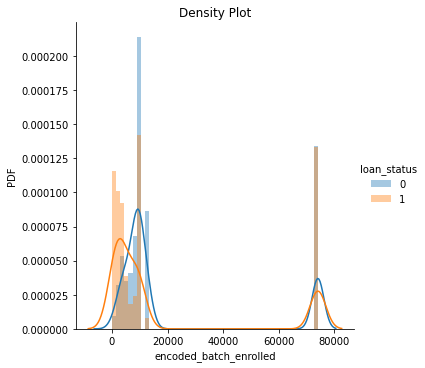

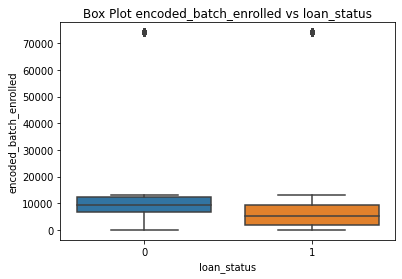

In [34]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'encoded_batch_enrolled').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('encoded_batch_enrolled')
plt.show()

sns.boxplot(x='loan_status',y='encoded_batch_enrolled', data=temp_df)
plt.title('Box Plot encoded_batch_enrolled vs loan_status')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


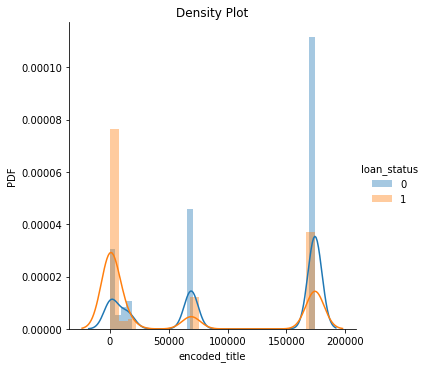

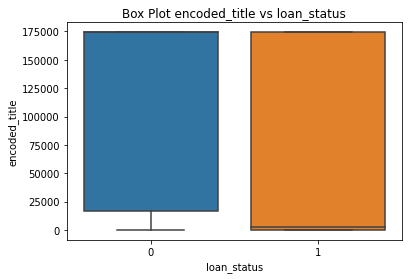

In [35]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'encoded_title').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('encoded_title')
plt.show()

sns.boxplot(x='loan_status',y='encoded_title', data=temp_df)
plt.title('Box Plot encoded_title vs loan_status')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


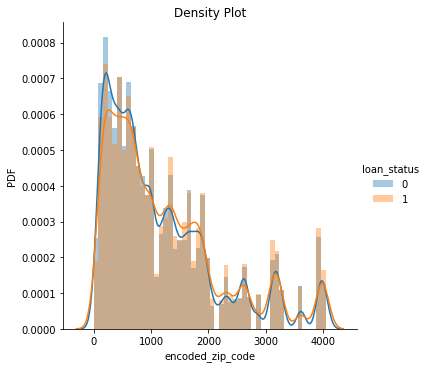

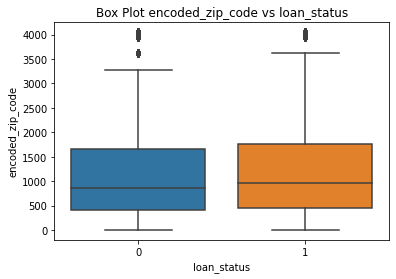

In [36]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'encoded_zip_code').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('encoded_zip_code')
plt.show()

sns.boxplot(x='loan_status',y='encoded_zip_code', data=temp_df)
plt.title('Box Plot encoded_zip_code vs loan_status')
plt.show()



/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


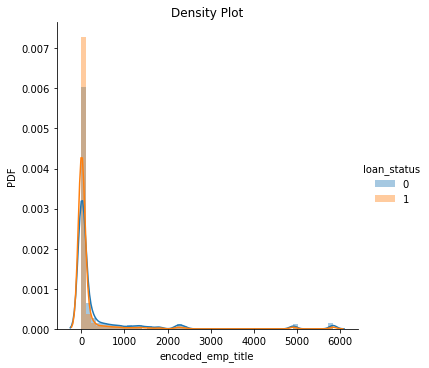

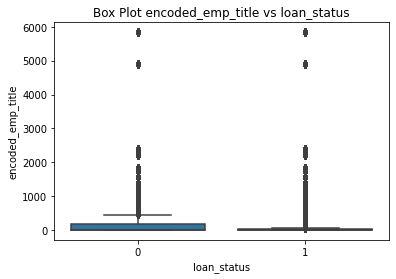

In [37]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'encoded_emp_title').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('encoded_emp_title')
plt.show()

sns.boxplot(x='loan_status',y='encoded_emp_title', data=temp_df)
plt.title('Box Plot encoded_emp_title vs loan_status')
plt.show()

Similaryly amongst these other numerical features 'loan_amnt', 'collections_12_mths_ex_med', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'revol_bal', 'revol_util', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'dti','mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'total_acc', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'acc_now_delinq'.

We see that total_rec_int, dti, loan_amnt, funded_amnt, funded_amnt_inv is able to distinguish the least.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


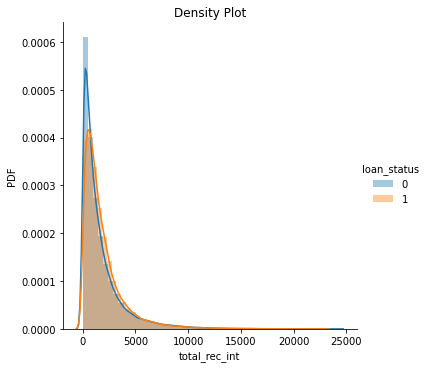

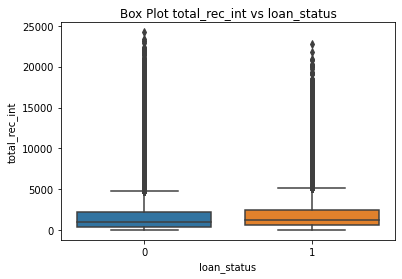

In [38]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'total_rec_int').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('total_rec_int')
plt.show()

sns.boxplot(x='loan_status',y='total_rec_int', data=temp_df)
plt.title('Box Plot total_rec_int vs loan_status')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


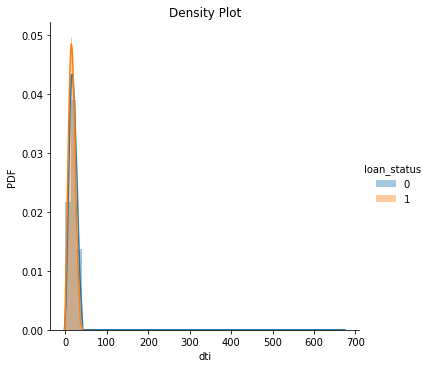

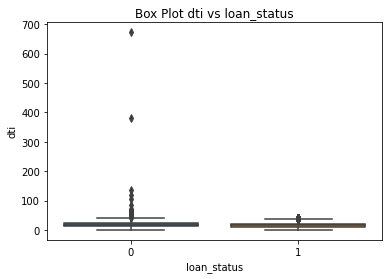

In [39]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'dti').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('dti')
plt.show()

sns.boxplot(x='loan_status',y='dti', data=temp_df)
plt.title('Box Plot dti vs loan_status')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


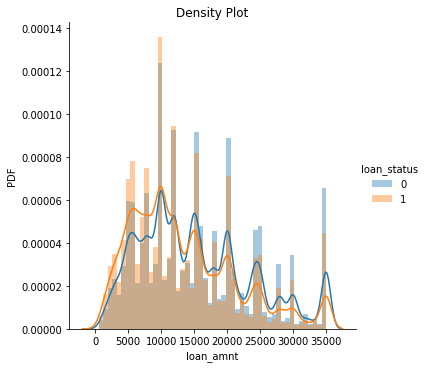

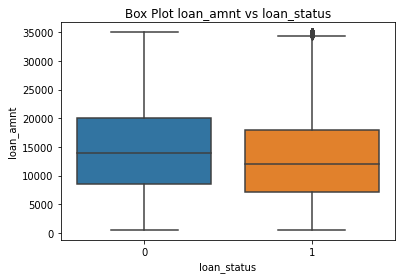

In [40]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'loan_amnt').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('loan_amnt')
plt.show()

sns.boxplot(x='loan_status',y='loan_amnt', data=temp_df)
plt.title('Box Plot loan_amnt vs loan_status')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


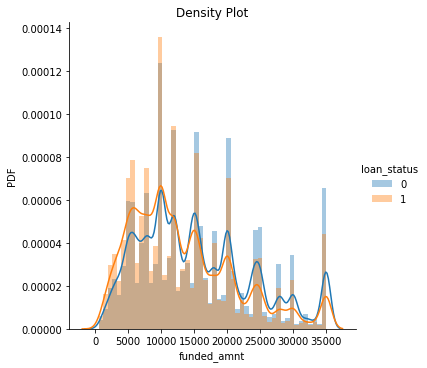

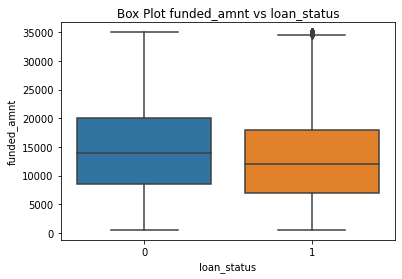

In [41]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'funded_amnt').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('funded_amnt')
plt.show()

sns.boxplot(x='loan_status',y='funded_amnt', data=temp_df)
plt.title('Box Plot funded_amnt vs loan_status')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


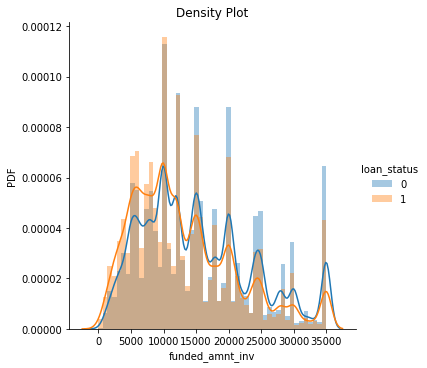

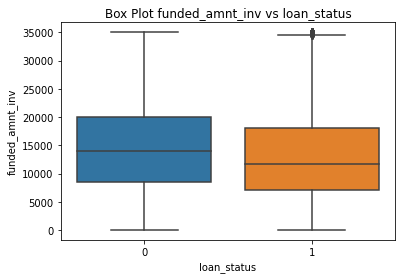

In [42]:
sns.FacetGrid(temp_df, hue='loan_status', size=5).map(sns.distplot, 'funded_amnt_inv').add_legend()
plt.title('Density Plot')
plt.ylabel('PDF')
plt.xlabel('funded_amnt_inv')
plt.show()

sns.boxplot(x='loan_status',y='funded_amnt_inv', data=temp_df)
plt.title('Box Plot funded_amnt_inv vs loan_status')
plt.show()

Now splitting the columns which have less than 100 categories with one hot encoding technique.
Now not going for frequency here this is more stable technique, and where we have huge no of categories 
there we can have frequency, response coding(here dint use as was taking huge amount of time 
to run due to column having 14k categories) kind of estimation.

IMP: Here when we were trying to split the categorical features further what issue we were getting was, 
there were 255 & 261 categories in test_indessa & train_indessa, also further we see after splitting train_indessa we see different no of categories which was causing issue while testing the
model and predicting for it. Hence, just to have same no iof categorical columns split what we tried was to concat 
both train test data , and then split. So now we have common no of categorical columns and then separated the data

In [81]:
# categorical cols to one hot
X_train_dropped['train'] = 1
X_test_dropped['train'] = 0
X_Unseen_test_dropped['train'] = -1
concat_train_test = pd.concat([X_train_dropped, X_test_dropped, X_Unseen_test_dropped])
df_dummy = pd.get_dummies(concat_train_test, columns = cat_cols_list)

In [82]:
df_dummy.shape

(887379, 266)

Here just dropping the extra identifier column from data, as now we have categorical splitting done

In [83]:
X_train_oneHot = df_dummy[df_dummy['train'] == 1]
X_test_oneHot = df_dummy[df_dummy['train'] == 0]
X_Unseen_test_oneHot = df_dummy[df_dummy['train'] == -1]
X_train_oneHot.drop(['train'], axis=1, inplace=True)
X_test_oneHot.drop(['train'], axis=1, inplace=True)
X_Unseen_test_oneHot.drop(['train'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [84]:
print(X_train_oneHot.shape)
print(X_test_oneHot.shape)
print(X_Unseen_test_oneHot.shape)

(372699, 265)
(159729, 265)
(354951, 265)


Scaling all the columns to brind them into 1 scale

In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oneHot)
X_test_scaled = scaler.fit_transform(X_test_oneHot)
X_Unseen_test_scaled = scaler.fit_transform(X_Unseen_test_oneHot)

In [86]:
X_train_scaled.shape
X_test_scaled.shape
X_Unseen_test_scaled.shape


(354951, 265)

batch predict function to predict for test results


In [87]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred


best parameters value hold

In [66]:

#here we are choosing the best_k
depth_best = 5
est_best = 500
lea_best = 0.05
best_gamma = 10


Suppose you have an unbalanced data with 80 percent 1 and rest 20 percent 0. 
Usually when we fit a model like logistic regression or random forest on such a dataset, 
there are high chances that the model is biased. These models might predict 1 for every 
data point and will still be correct 80% of the times. We have class_weights parameters in Logistic & Random Forest classifier but here we are going with much powerful boosting technique.

XGBoost implementation of GBDT is a sequential process and thus every time it makes an incorrect prediction, 
it focuses more on that incorrectly predicted data point. So, if the first iteration gave you 
an accuracy of 80 %, the second iteration would focus on the remaining 20%.

Applying XGBoost

In [63]:
from sklearn.metrics import roc_curve, auc

dec = XGBClassifier(max_depth=depth_best, n_estimators=est_best, gamma=best_gamma, learning_rate= lea_best)
dec.fit(X_train_scaled, y_train)

y_train_pred = batch_predict(dec, X_train_scaled)    
y_test_pred = batch_predict(dec, X_test_scaled)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

Here below we see that train & test auc are almost equal, hence model is not overfitting.

In [64]:
depth_best

5

AUC-ROC curve for train & test

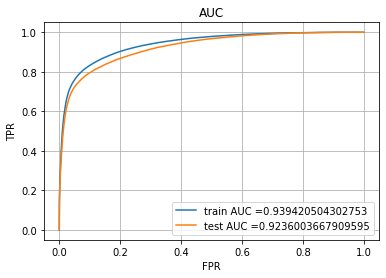

In [65]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()
plt.show()

Utilities for finding best threshold, predicting by best threshold

In [67]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


1- Function to find best threshold from train 2- function to find predict y from best threshold


In [68]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.7491209046448486 for threshold 0.22
Train confusion matrix
[[254613  30007]
 [ 14321  73758]]
Test confusion matrix
[[104167  17814]
 [  6284  31464]]


Checking model count behavior

In [69]:
a= predict_with_best_t(y_train_pred, best_t)
b= predict_with_best_t(y_test_pred, best_t)
print(a.count(0), a.count(1))

print(b.count(0), b.count(1))

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

268934 103765
110451 49278
(array([0, 1]), array([284620,  88079]))
(array([0, 1]), array([121981,  37748]))


Best threshold

In [70]:
best_t

0.22005935

Predicting the probabilistic values for each point and corresponding class label

In [71]:
y_unseen_pred = np.array(batch_predict(dec, X_Unseen_test_scaled))
y_unseen_pred_loan_status = np.array(predict_with_best_t(y_unseen_pred, best_t))

In [72]:
print(y_unseen_pred)
print(y_unseen_pred_loan_status[:20])

print(y_unseen_pred.shape)
print(y_unseen_pred_loan_status.shape)

[0.7298034  0.5082688  0.4591312  ... 0.62018645 0.7917276  0.7114269 ]
[1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0]
(354951,)
(354951,)


Holding & consolidating all in a dataframe

In [77]:
df_predicted_finally_test_labels = pd.DataFrame(columns=['member_id', 'loan_status', 'predicted_labels_best_threshold'])
df_predicted_finally_test_labels['member_id'] = X_Unseen_test['member_id']
df_predicted_finally_test_labels['loan_status'] = y_unseen_pred
df_predicted_finally_test_labels['predicted_labels_best_threshold'] = y_unseen_pred_loan_status


Hence, below we see that from test set given 70.11% will be marked as 1(defaulter) by model

In [79]:
print(df_predicted_finally_test_labels.shape)
df_predicted_finally_test_labels['predicted_labels_best_threshold'].value_counts()

(354951, 3)


1    248863
0    106088
Name: predicted_labels_best_threshold, dtype: int64

Saving results to a file

In [ ]:
df_predicted_finally_test_labels.to_csv('result_submission.csv')
!cp result_submission.csv "drive/My Drive/"